In [1]:
import os.path
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import kde
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.special import erfinv
from matplotlib.colors import LogNorm

plotId = 0
smallFiles = False
outTag='DataSimCh'
debug = False

#settings
plt.style.use('fast')
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.linewidth'] = 3.0
matplotlib.rcParams['hist.bins'] = 'auto'
matplotlib.rcParams['text.usetex'] = 'true'
#matplotlib.rcParams['text.latex.unicode']= 'true' #deprecated from Matplotlib 3.0
matplotlib.rcParams['image.cmap'] = 'RdYlBu_r' #'hot'
matplotlib.rcParams['font.size'] = 22
#print(matplotlib.rcParams)

#Common offset for ACP80 runs
gonio_zero = 1570840.0/1000. #mrad
thetaInx_bias = 0.005  #mrad : difference between nominal '0' and crystal plane '0'

#useful labels
d0xL=r"$d_0^{x}$ [mm]"
d0yL=r"$d_0^{y}$ [mm]"
tInXL=r"$\theta_{in}^{x}$ [mrad]"
tInYL=r"$\theta_{in}^{y}$ [mrad]"
tOutXL=r"$\theta_{out}^{x}$ [mrad]"
tOutYL=r"$\theta_{out}^{y}$ [mrad]"
dtL=r"$\Delta\theta_{(out-in)}$ [mrad]"

#useful binning/range
d0xR=[-2.,2.]
d0yR=[-2.,2.]
tInXR=[-0.1,0.1]
tInYR=[-0.1,0.1]
tOutXR=[-0.2,0.2]
tOutXGonioR=[-0.15-gonio_zero,+0.15-gonio_zero]
tOutYR=[-0.1,0.1]
#
nBd0=20
nBth=20
nBd0F=50
nBthF=50

colorsP=['Reds','Blues','Greens','Oranges','Purples','Greys','viridis','Reds','Blues','Greens','Oranges','Purples','Greys']
colors=['r','b','g','orange','purple','grey','teal','r','b','g','orange','purple','grey']


folder= "../BigDataFiles/"

inputFiles=[]
whichFiles='Comp' # 'Sim','Data','All','Comp'

if whichFiles is 'Data' or whichFiles is 'All' :
    inputFiles.append(folder+"ACP80_min90_flt.dat")
    inputFiles.append(folder+"ACP80_min70_flt.dat")
    inputFiles.append(folder+"ACP80_min50_flt.dat")
    inputFiles.append(folder+"ACP80_0_flt.dat") ######################### zero
    inputFiles.append(folder+"ACP80_plus10_flt.dat")
    #inputFiles.append(folder+"ACP80_6534.dat") #this is actually a 'plus20'
    inputFiles.append(folder+"ACP80_plus50_flt.dat")
    inputFiles.append(folder+"ACP80_plus55_flt.dat")
if whichFiles is 'Sim' or whichFiles is 'All' :
    #inputFiles.append(folder+"mUA9SimSqEne180_0_NoCryst_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min90_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min80_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min70_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min60_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min55_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min50_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min45_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min40_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min35_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min30_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min25_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min20_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min15_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min10_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_min5_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_0_N10000.dat") ################## zero
    inputFiles.append(folder+"mUA9SimSqEne180_plus5_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_plus10_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_plus15_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_plus20_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_plus25_N10000.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_plus40_N10000.dat")
if whichFiles is 'Comp':
    #This should be used custom to compare Sim to Data
    inputFiles.append(folder+"ACP80_0_flt.dat")
    inputFiles.append(folder+"mUA9SimSqEne180_0_N10000.dat")

for iF in inputFiles:
    if not os.path.isfile(iF) :
        print("WARNING - File not found:", iF, ". I will ignore that!")
        inputFiles.remove(iF)
        
print('INFO - processing the following files:')
print(*inputFiles, sep = "\n")

inFileLabels=[]
for iF in inputFiles:
    inFileLabels.append(iF.split("/")[-1].split(".")[0].replace("_"," "))

angles=[]
for iF in inputFiles:
    angle = iF.split("/")[-1].split(".")[0].split("_")[1].replace("min","-").replace("plus","")
    if angle == '6534': angle='20'
    angles.append(int(angle))
print('INFO - files in the list above corresponds to the following angles (urad):')    
print(angles)
try:
    idxZero = angles.index(0) #This is looking for the file at angle 0. If you get an error check
    print("Reference (0) file:",inputFiles[idxZero])
except ValueError as e:
    print('Error when looking for angle 0:',e)
    print('WARNING - The absence of this file will cause seriouse issues')
    
while len(inputFiles) > len(colors):
    colors=colors+colors
    colorsP=colorsP+colorsP
    print(colorsP)

cols=["gonio_angle","d0_x","d0_y","thetaIn_x","thetaOut_x","thetaIn_y","thetaOut_y","unknown1","unknown2"]

INFO - processing the following files:
../BigDataFiles/ACP80_0_flt.dat
../BigDataFiles/mUA9SimSqEne180_0_N10000.dat
INFO - files in the list above corresponds to the following angles (urad):
[0, 0]
Reference (0) file: ../BigDataFiles/ACP80_0_flt.dat


In [2]:
def emittanceRMS(x,y):
    rmsX = np.std(x)
    rmsY = np.std(y)
    #print(np.corrcoef(x,y))
    det = np.linalg.det(np.corrcoef(x,y))
    #print(rmsX,rmsY,det)
    return rmsX*rmsY*math.sqrt(det)

def plot2D(ax,x,y,xlabel,ylabel,bins,rng,cmap):
    plot= ax.hist2d(x, y, bins=bins,range=rng,  cmap=cmap)
    ax.set_xlabel(xlabel, fontsize='20')
    ax.set_ylabel(ylabel, fontsize='20')
    return ax

def plot1D(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None,weights=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    if log: ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng)
    #ax.legend(loc= "best")
    ax.grid(True)
    return ax

def plot1DNorm(ax,x,label,xlabel,ylabel,log,col,bins=None,rng=None):
    ax.set_xlabel(xlabel,fontsize='20')
    ax.set_ylabel(ylabel,fontsize='20')
    ax.set_ylim(auto=True)
    ax.hist(x,log=log,histtype='step', label=label, color=col, bins=bins, range=rng, density=True)
    #ax.legend(loc= "lower right")
    ax.grid(True)
    return ax

In [3]:
datasetsI = []
for iF in inputFiles:
    datasetI = pd.read_csv(iF,header=None,names=cols)
    datasetI["gonio_angle"]=datasetI["gonio_angle"]/1000.
    datasetI["thetaIn_x"]=datasetI["thetaIn_x"]*1000.
    datasetI["thetaOut_x"]=datasetI["thetaOut_x"]*1000.
    datasetI["thetaIn_y"]=datasetI["thetaIn_y"]*1000.
    datasetI["thetaOut_y"]=datasetI["thetaOut_y"]*1000.
    datasetI["deltaTheta"] = datasetI["thetaOut_x"]-datasetI["thetaIn_x"]
    datasetI["deltaGonio"] = datasetI["gonio_angle"]-gonio_zero
    datasetI["weight"] = 1.
    if iF==folder+"ACP80_min70_flt.dat":
        datasetI["deltaGonio"] = datasetI["deltaGonio"]-3252.2186 #3252.0786
    if "mUA9Sim" in iF:
        print(iF, ": this is a MC simulated sample.")
        datasetI["deltaGonio"] = -1*datasetI["gonio_angle"] #no offset in this case
    else :
        print(iF, ": this is a Data sample.")
        
    if debug : print(datasetI.iloc[0,:])
    datasetsI.append(datasetI)

../BigDataFiles/ACP80_0_flt.dat : this is a Data sample.
../BigDataFiles/mUA9SimSqEne180_0_N10000.dat : this is a MC simulated sample.


In [4]:
datasets = []
for ds in datasetsI:
    #pass the initial dataset to the one you'll manipulate
    dataset = ds
    # append to list
    datasets.append(dataset)
print("Analyzing %d datasets"%len(datasets))
nds=len(datasets)

Analyzing 2 datasets


## Now we make some plot to have a first glance at the distribution

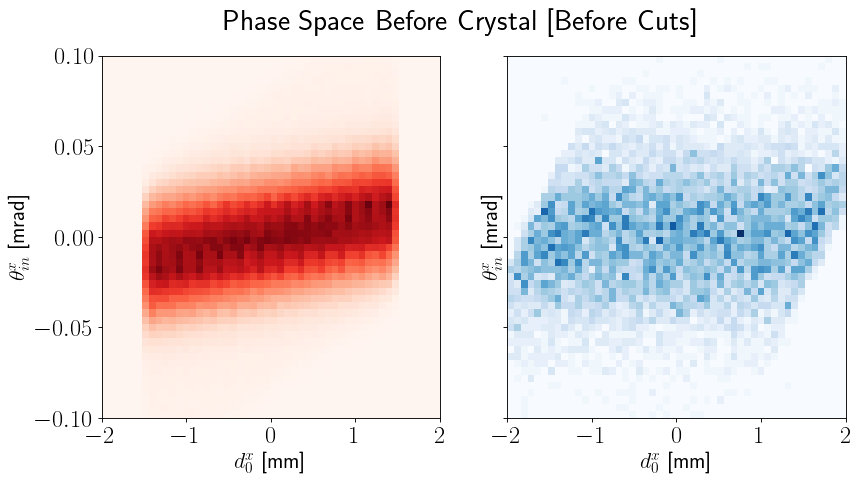

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k", sharey=True)
fig.suptitle("Phase Space Before Crystal [Before Cuts]")
for i in range(nds):
    plot2D(axes[i],
           datasets[i]["d0_x"],
           datasets[i]["thetaIn_x"],
           d0xL,
           tInXL,
           (nBd0F,nBthF),
           [d0xR,tInXR],
           colorsP[i]
          )
plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Let's have a look at particle deflection due to the crystal

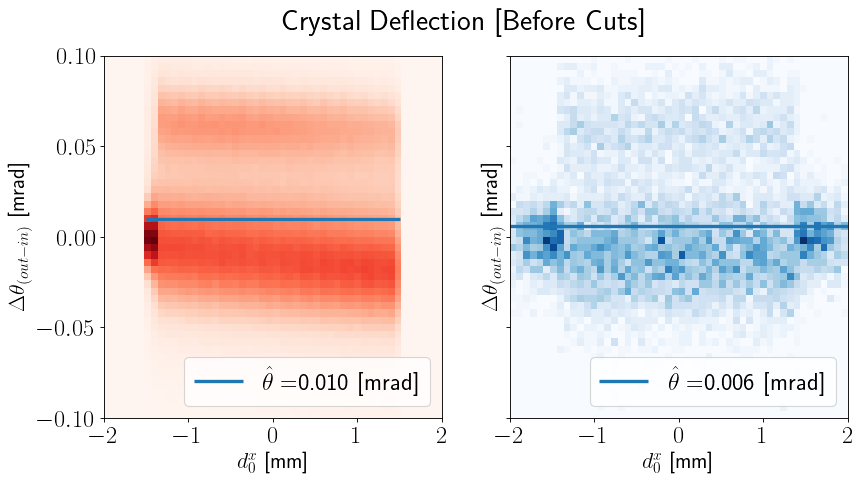

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k", sharey=True)
fig.suptitle("Crystal Deflection [Before Cuts]")
plots = []
medias = []
for i in range(nds):
    plots.append(
                plot2D(axes[i],
                datasets[i]["d0_x"],
                datasets[i]["deltaTheta"],
                d0xL,
                dtL,
                (nBd0F,nBthF),
                [d0xR,[-0.1,0.1]],
                colorsP[i]
                )
                )
    medias.append(np.mean(datasets[i]["deltaTheta"]))
    plots[-1].hlines(medias[-1], 
                     np.min(datasets[i]["d0_x"]), 
                     np.max(datasets[i]["d0_x"]), 
                     label=(r"$\hat\theta=${:.3f} [mrad]".format(medias[-1]))
                    )
    plots[-1].legend(loc= "lower right")
plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

### Let's add some cuts!
    - In the incoming angle in order to choose particles that are going to be channeled (Crit. angle for this 180GeV case is +-15urad: general formula is sqrt(4/E[GeV])*100urad )
    - In x (raw cut on data was +- 1.5mm), we can reduce the data sample to those within +- 1mm
    - In y since we want to avoid problems related with the crystal torsion   
## We have now only particles entering within +-ThetaCrit
    

In [7]:
applyCut = True
applyWeight = False
max_d0x = 1.
max_d0y = 1.5
max_thetaInx = 0.015 #15urad

if applyCut:
    for i in range(len(datasets)):
        dataset = datasets[i]
        dataset = dataset[abs(dataset.d0_x)<max_d0x]
        dataset = dataset[abs(dataset.d0_y)<max_d0y]
        dataset = dataset[abs(dataset.thetaIn_x+thetaInx_bias)<max_thetaInx]
        datasets[i] = dataset

## Let's look again at the phase space after these cuts

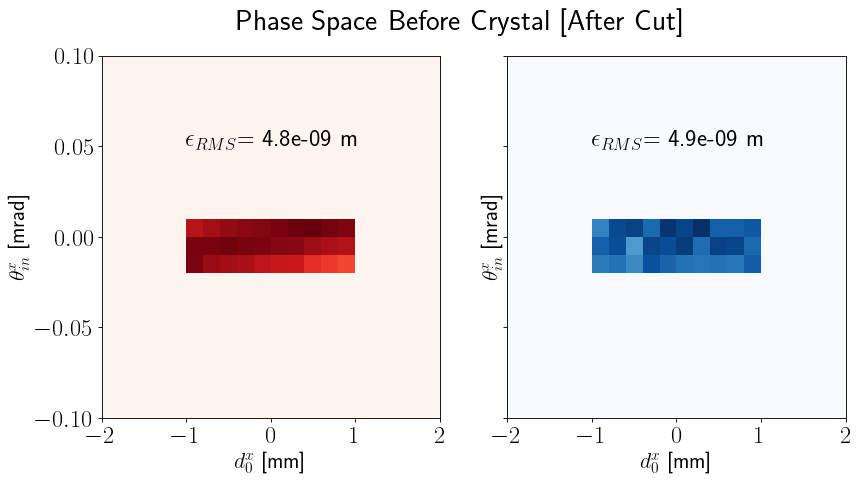

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k", sharey=True)
fig.suptitle("Phase Space Before Crystal [After Cut]")
plots=[]
for i in range(nds):
    plots.append(plot2D(axes[i],datasets[i]["d0_x"],datasets[i]["thetaIn_x"],d0xL,tInXL,
           (nBd0,nBth),[d0xR,tInXR],colorsP[i]))
    plots[-1].text(-1.,.05,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(datasets[i]["d0_x"],datasets[i]["thetaIn_x"])))

plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Let's have a look at some plots to better understand the distribution after the cuts

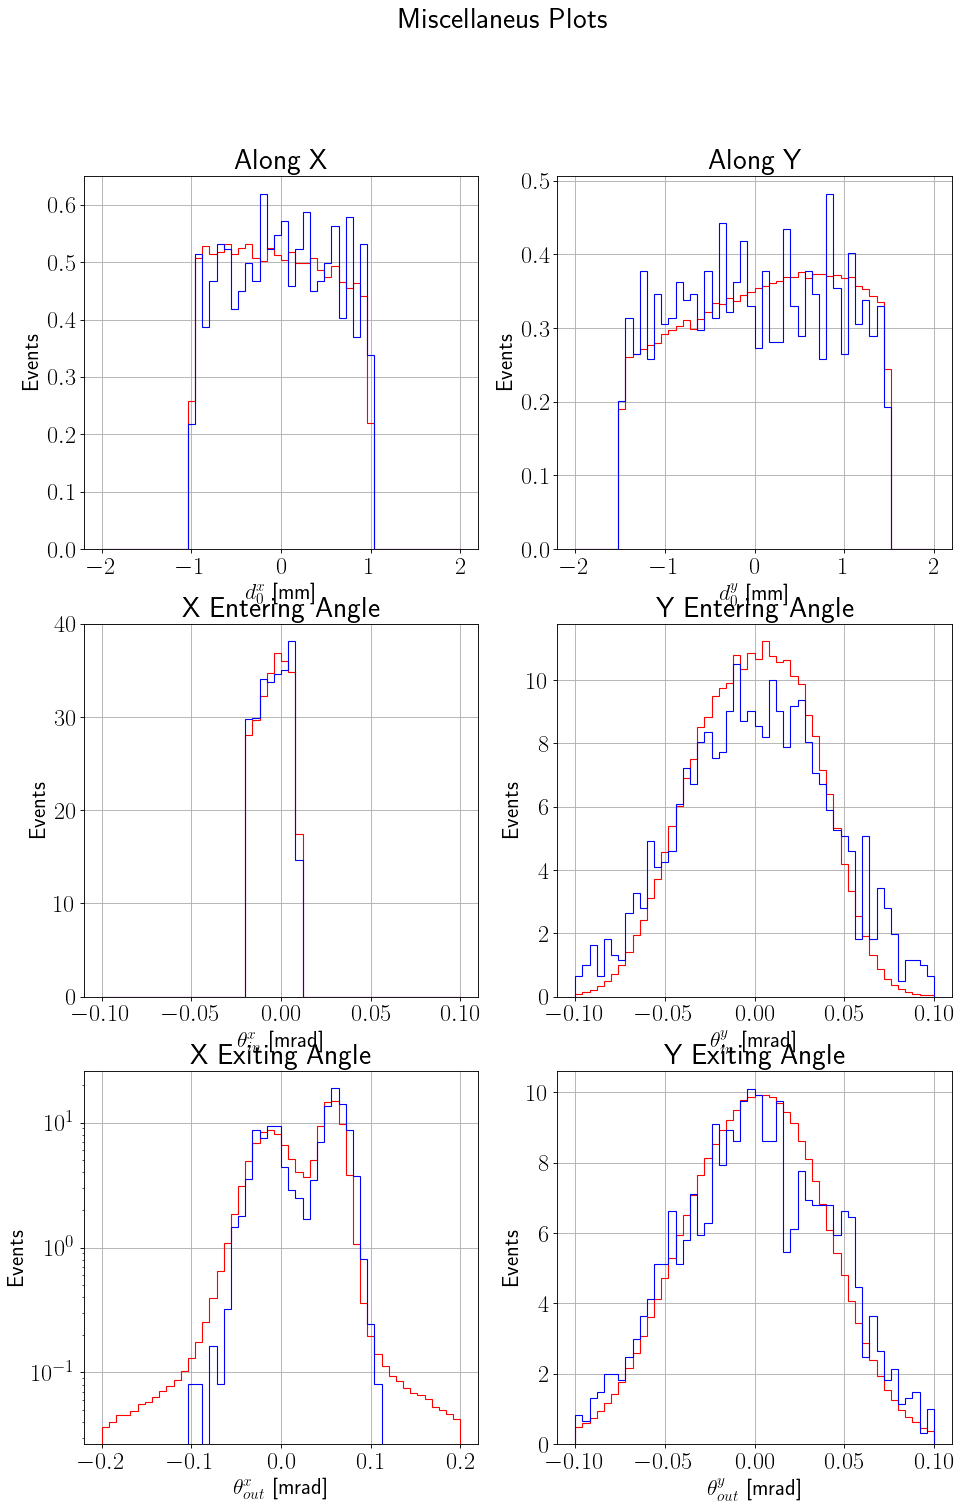

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(7*2, 7*3),dpi=80, facecolor = "w", edgecolor = "k")
fig.suptitle("Miscellaneus Plots")

axes[0][0].set_title("Along X")
axes[0][1].set_title("Along Y")
axes[1][0].set_title("X Entering Angle")
axes[1][1].set_title("Y Entering Angle")
axes[2][0].set_title("X Exiting Angle")
axes[2][1].set_title("Y Exiting Angle")

for i in range(nds):
    plot1DNorm(axes[0][0],datasets[i]["d0_x"],inFileLabels[i],d0xL,"Events",
           False,colors[i],nBd0F,d0xR)
    plot1DNorm(axes[0][1],datasets[i]["d0_y"],inFileLabels[i],d0yL,"Events",
       False,colors[i],nBd0F,d0yR)
    plot1DNorm(axes[1][0],datasets[i]["thetaIn_x"],inFileLabels[i],tInXL,"Events",
       False,colors[i],nBthF,tInXR)
    plot1DNorm(axes[1][1],datasets[i]["thetaIn_y"],inFileLabels[i],tInYL,"Events",
       False,colors[i],nBthF,tInYR)
    plot1DNorm(axes[2][0],datasets[i]["thetaOut_x"],inFileLabels[i],tOutXL,"Events",
       True,colors[i],nBthF,tOutXR)
    plot1DNorm(axes[2][1],datasets[i]["thetaOut_y"],inFileLabels[i],tOutYL,"Events",
       False,colors[i],nBthF,tOutYR)

plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Now we want to evaluate the efficiency (in terms of number of particles) of the two processes:
    - Channeling (red)
    - Volume Reflection (blue)
### NOTE: there are subtelties below to have the fit converging. Needs rearranging. Examples are
```
if i in [0,1,2,3,4,5,6]: #[0,1,2,10]:
```
or 
```
abs(datasets[i].deltaTheta-0.055)
```
which seems to be shifting the fit-window center to 55.
We need to implement a range which is dependent on the histo center or something similar

Dataset (0) lenght:  4435169
Bin width:  0.003


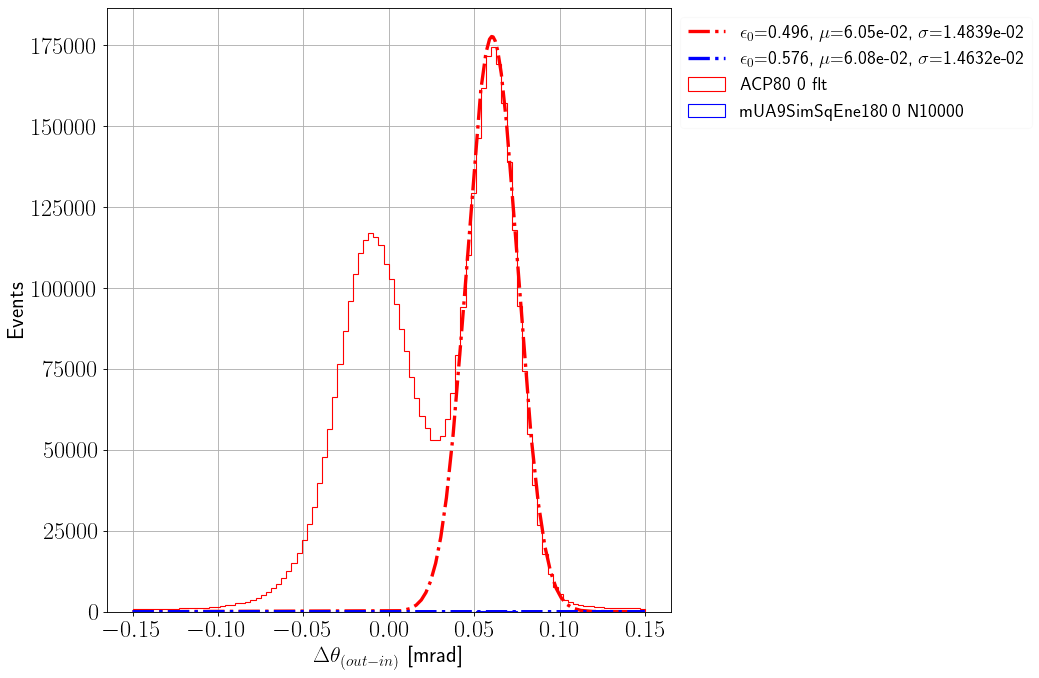

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 178
    # data points      = 13
    # variables        = 3
    chi-square         = 75578029.9
    reduced chi-square = 7557802.99
    Akaike info crit   = 208.484449
    Bayesian info crit = 210.179297
[[Variables]]
    amplitude:  6604.84017 +/- 64.7605269 (0.98%) (init = 1)
    center:     0.06047836 +/- 1.3330e-04 (0.22%) (init = 0)
    sigma:      0.01483910 +/- 1.9163e-04 (1.29%) (init = 1)
    fwhm:       0.03494341 +/- 4.5126e-04 (1.29%) == '2.3548200*sigma'
    height:     177568.043 +/- 1285.46213 (0.72%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.831
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 158
    # data points      = 13
    # variables        = 3
    chi-square         = 770.892151
    reduced chi-square = 77.0892151
   

In [10]:
xmin=-0.15
xmax=0.15
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(2*10, 10),dpi=80,facecolor='w', edgecolor='k')

print("Dataset (0) lenght: ",datasets[idxZero].shape[0])
cBW=max(((xmax-xmin)*10./datasets[idxZero].shape[0]),0.003) #was 0.001
print("Bin width: ",cBW)

for i in range(nds):
    plot1D(ax[0],datasets[i]["deltaTheta"],inFileLabels[i],dtL,"Events",
            False,colors[i],int((xmax-xmin)/cBW),[xmin,xmax])

if True:
    from lmfit.models import GaussianModel
    mods = []
    outs = []
    predictions = []
    efficiencies = []
    effUnc = []
    for i in range(nds):
        mods.append(GaussianModel())
        #if i in [0,1,2,3,4,5,6,7]: #[0,1,2,10]:
        if angles[i]< 15 and angles[i]>-25:
            os_fit_range = 0.02 #one-sided fit range around the channeled peak
            data_entries, bins = np.histogram(datasets[i][abs(datasets[i].deltaTheta-0.061)<os_fit_range]["deltaTheta"], bins=int(2*os_fit_range/cBW))
        else:
            os_fit_range = 0.1 #one-sided fit range around zero
            data_entries, bins = np.histogram(datasets[i][abs(datasets[i].deltaTheta)<os_fit_range]["deltaTheta"], bins=int(2*os_fit_range/cBW))
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        pars = mods[-1].guess(data_entries, x=data_entries)
        out = mods[-1].fit(data_entries.astype(float), x=binscenters.astype(float))
        outs.append(out)
        predicted = outs[-1].eval(x=np.linspace(xmin, xmax, 1000))
        predictions.append(predicted)
        efficiencies.append((outs[-1].params['amplitude'].value)/cBW/(len(datasets[i]["deltaTheta"])))
        #effUnc.append((outs[-1].params['amplitude'].stderr)/cBW/(len(datasets[i]["deltaTheta"])))
        ax[0].plot(np.linspace(xmin, xmax, 1000), predictions[-1], color=colors[i], linestyle='-.', 
                 label=(r"$\epsilon_{{{}}}$={:.3f}, $\mu$={:.2e}, $\sigma$={:.4e}".format(inFileLabels[i].split(" ")[1],
                                                                                          ((outs[-1].params['amplitude'].value)/cBW/(len(datasets[i]["deltaTheta"]))), outs[-1].params['center'].value, outs[-1].params['sigma'].value)))
        ax[0].grid(True)
    leg = ax[0].legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=17)
    leg.get_frame().set_alpha(0.1)
    ax[1].remove()
    plt.show()
    fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
    plotId+=1
    for i in range(nds):
        print(outs[i].fit_report())


## Now we want to imitate the famous H8 plot

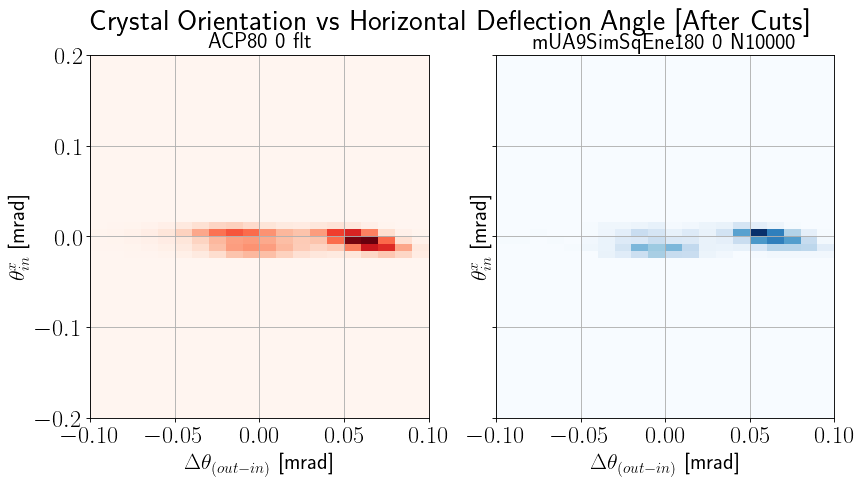

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k", sharey=True)
fig.suptitle("Crystal Orientation vs Horizontal Deflection Angle [After Cuts]")
plots=[]
for i in range(nds):
    plots.append(
            plot2D(axes[i],datasets[i]["deltaTheta"],datasets[i]["thetaIn_x"]-datasets[i]["deltaGonio"],
                   dtL,tInXL,(nBth,nBthF),[[-.1,.1],tOutXR],colorsP[i])
                )
    plots[-1].set_title(inFileLabels[i],fontsize=20)
    plots[-1].grid(True)

plt.show()
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

## Now let's mimic the effect of a magnetic septum that cleans the channeled beam

In [12]:
#mimic the presence of the septum
septumFlag = False
thetaDeflection = 0.061 #this is the deflection angle
thetaAcceptance = 0.030 #this is an angular acceptance around the deflection angle

if septumFlag:
    print('INFO - a septum is applied selecting +/-',thetaAcceptance,'around the deflection angle',thetaDeflection,'urad.')
    for ds in datasets:
        ds = ds[abs(ds["thetaOut_x"]-ds["detlaGonio"]-thetaDeflection)<thetaAcceptance]
else:
    print('INFO - be aware that no septum is applied!')

INFO - be aware that no septum is applied!


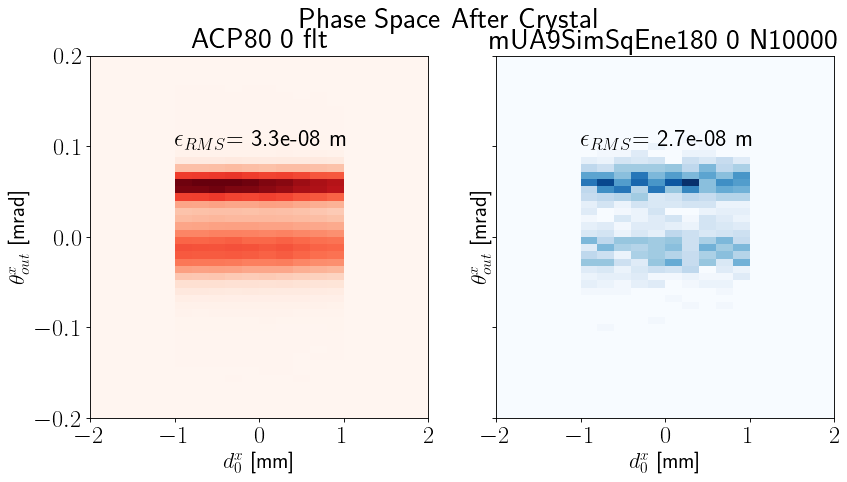

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=nds,figsize=(6*nds, 6),dpi=80, facecolor = "w", edgecolor = "k", sharey=True)
fig.suptitle("Phase Space After Crystal")
plots=[]
for i in range(nds):
    plots.append(
                plot2D(axes[i],datasets[i]["d0_x"],datasets[i]["thetaOut_x"]-datasets[i]["deltaGonio"],
                d0xL,tOutXL,(nBd0,nBthF),[d0xR, tOutXR],colorsP[i])
                )
    plots[-1].set_title(inFileLabels[i])
    plots[-1].text(-1.,0.1,r"$\epsilon_{{RMS}}$= {:.1e} m".format(1e-6*emittanceRMS(datasets[i]["d0_x"],datasets[i]["thetaOut_x"]+datasets[i]["gonio_angle"])))

plt.show()

fig.savefig("beams.png")
fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

0.003


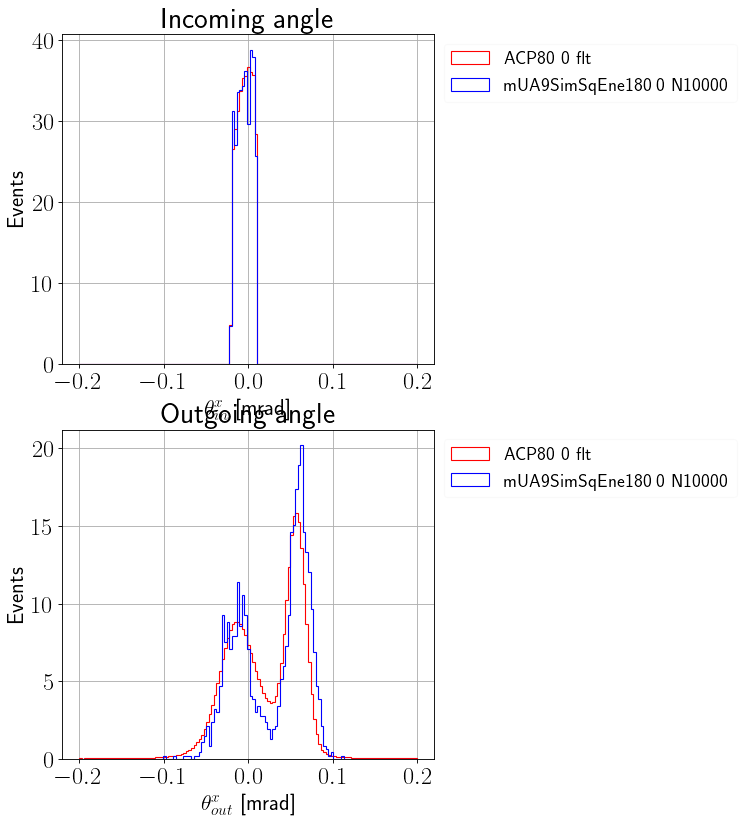

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(6, 6*2),dpi=80,facecolor='w', edgecolor='k')

xmin=-0.2
xmax=0.2
#commonBinWidth=max(int(0.5*1000./datasets[idxZero].shape[0])/100.,0.01) #0.001
cBW=max(((xmax-xmin)*10./datasets[idxZero].shape[0]),0.003) #was 0.001
#cBW=0.005
print(cBW)

plots=[]
for i in range(nds):
    plots.append(
                plot1DNorm(ax[0],datasets[i]["thetaIn_x"]-datasets[i]["deltaGonio"],inFileLabels[i],tInXL,"Events",
                False,colors[i],int((xmax-xmin)/cBW),[xmin,xmax])
                )
    plots.append(
                plot1DNorm(ax[1],datasets[i]["thetaOut_x"]-datasets[i]["deltaGonio"],inFileLabels[i],tOutXL,"Events",
                False,colors[i],int((xmax-xmin)/cBW),[xmin,xmax])
                )
#ax[0].set_ylim(0.,70.)
#ax[1].set_ylim(0.,40.)
ax[0].title.set_text('Incoming angle')
ax[0].legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=17)
ax[0].get_legend().get_frame().set_alpha(0.1)
ax[1].title.set_text('Outgoing angle')
ax[1].legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=17)
ax[1].get_legend().get_frame().set_alpha(0.1)
fig.savefig("plot_{:d}_{:d}.png".format(nds,plotId))
plotId+=1

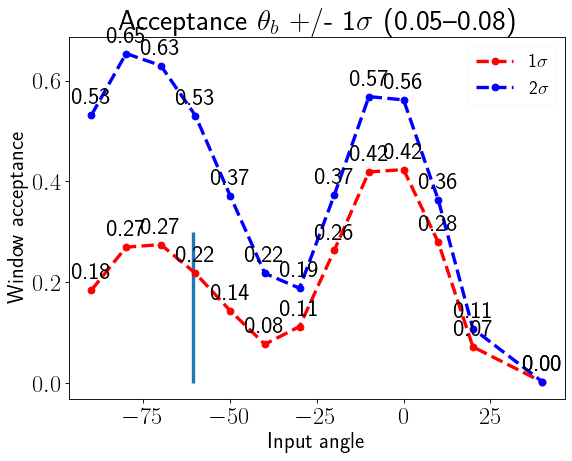

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 6),dpi=80,facecolor='w', edgecolor='k')

outCenter = outs[idxZero].params['center'].value
outMin = outs[idxZero].params['center'].value-outs[idxZero].params['sigma'].value
outMax = outs[idxZero].params['center'].value+outs[idxZero].params['sigma'].value
out2Min = outs[idxZero].params['center'].value-2*outs[idxZero].params['sigma'].value
out2Max = outs[idxZero].params['center'].value+2*outs[idxZero].params['sigma'].value

acceptance1S=[]
acceptance2S=[]
for i in range(nds):
    currDS = datasets[i]
    currDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])>outMin)]
    tmpDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])<outMax)]
    acceptance1S.append(tmpDS.shape[0]/datasets[i].shape[0])
for i in range(nds):
    currDS = datasets[i]
    currDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])>out2Min)]
    tmpDS = currDS[((currDS["thetaOut_x"]-currDS["deltaGonio"])<out2Max)]
    acceptance2S.append(tmpDS.shape[0]/datasets[i].shape[0])
    #print("Window acceptance: {:s} {:.2f}".format(inFileLabels[i],acceptance[-1]))
    
xs,y1s = zip(*sorted(zip(angles,acceptance1S)))
xs,y2s = zip(*sorted(zip(angles,acceptance2S)))
ax.plot(xs,y1s,'--or',label='1$\sigma$')
ax.plot(xs,y2s,'--ob',label='2$\sigma$')
ax.title.set_text(r'Acceptance $\theta_b$ +/- 1$\sigma$ ({:.2f}--{:.2f})'.format(outMin,outMax))
ax.set_xlabel('Input angle',fontsize='20')
ax.set_ylabel('Window acceptance',fontsize='20')
ax.vlines(outCenter*-1000,0.0,0.3)
ax.legend(loc="best", bbox_to_anchor=(1,1), fontsize=17)
ax.get_legend().get_frame().set_alpha(0.1)
for x,y in zip(xs,y1s):
    label = "{:.2f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')
for x,y in zip(xs,y2s):
    label = "{:.2f}".format(y)
    plt.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')

fig.savefig("plot_{:s}_{:d}.png".format(outTag,plotId))
plotId+=1

In [ ]:
if True:
    outFile = open('Acceptances.txt','a')
    outFile.write('########################\n')
    xs,y1s,y2s,labels = zip(*sorted(zip(angles,acceptance1S,acceptance2S,inFileLabels)))
    for ix,iy1,iy2,ilab in zip(xs,y1s,y2s,labels):
        outFile.write("{:d} {:.3f} {:.3f} {:s}\n".format(ix,iy1,iy2,ilab.replace(" ","_")))
    outFile.close()